# Webmining - Assignment 2

This **Home Assignment** is to be submitted and you will be given points for each of the tasks. It familiarizes you with basics of Markov Chain and link prediction on graphs.

## Formalities
**Submit in a group of 2-3 people until 16.06.2020 23:59CET. The deadline is strict!**

## Evaluation and Grading
General advice for programming excercises at *CSSH*:
Evaluation of your submission is done semi automatically. Think of it as this notebook being 
executed once. Afterwards, some test functions are appended to this file and executed respectively.

Therefore:
* Submit valid _Python3_ code only!
* Use external libraries only when specified by task.
* Ensure your definitions (functions, classes, methods, variables) follow the specification if
  given. The concrete signature of e.g. a function usually can be inferred from task description, 
  code skeletons and test cases.
* Ensure the notebook does not rely on current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
  * Double check if your code relies on presence of files or directories other than those mentioned
    in given tasks. Tests run under Linux, hence don't use Windows style paths 
    (`some\path`, `C:\another\path`). Also, use paths only that are relative to and within your
    working directory (OK: `some/path`, `./some/path`; NOT OK: `/home/alice/python`, 
    `../../python`).
* Keep your code idempotent! Running it or parts of it multiple times must not yield different
  results. Minimize usage of global variables.
* Ensure your code / notebook terminates in reasonable time.

**There's a story behind each of these points! Don't expect us to fix your stuff!**

Regarding the scores, you will get no points for a task if:
- your function throws an unexpected error (e.g. takes the wrong number of arguments)
- gets stuck in an infinite loop
- takes much much longer than expected (e.g. >1s to compute the mean of two numbers)
- does not produce the desired output (e.g. returns an descendingly sorted list even though we asked for ascending, returns the mean and the std even though we asked for only the mean, prints an output instead of returning it, ...)

# Task 1: Markov chains (6 points total)

For this task you are only allowed to use numpy and pandas. For this task always include the RESET states.

### Information: data structures for this assignment:
A *state* or *item* is always given by a string.
A uni-variate sequence is given (or should be implemented as) a list of states (strings).

Example:

```uni_variate_sequence = ["a", "c", "b", "a"]```

```list_of_sequences =  [["a"], ["a", "b", "c"], ["a", "c"], ["c"]]```

We usually refer to a list of sequences as just `sequences`

## 1a) Transitions generator (1)
Write a function `generate_transitions(sequences, order, include_RESET=True)` that loops over each of the sequences in the provided list of sequences and `yield`s one transition after another. A transition is a tuple where the first element is a tuple containing the relevant history (i.e. one element for order 1, two elements for order two ...). The second element is the next state. Also include the RESET transitions. Whether reset states should be included can be specified through `include_RESET`. Use `"RESET"` as the indicating string of the reset state (you can assume this string does not occur in the data otherwise). If a sequence is shorter than order + 1 and include_RESET = False, omit that sequence.

Example:
```python
test_sequences = [["a", "b"]]
list(generate_transitions(test_sequences, order))
# order=1 [(('RESET',), 'a'), (('a',), 'b'), (('b',), 'RESET')]
# order=2 [(('RESET', 'RESET'), 'a'), (('RESET', 'a'), 'b'), (('a', 'b'), 'RESET')]
test_sequences = [["a"], ["b"]]
list(generate_transitions(test_sequences, 1))
# order=1 [(('RESET',), 'a'), (('a',), 'RESET'), (('RESET',), 'b'), (('b',), 'RESET')]
```


## 1b) Fitting the model (1)
Implement the function `fit_mc(sequences, order)` that fits a Markov chain of a specific `order` to the given input of a list of sequences.
The function should return t_m, row_names, col_names with

* `t_m`: transition_probability matrix (2-d numpy array of type float)
* `row_names`: List of source state tuples in the ordering used in the array. 
* `col_names`: List of the target states in the ordering used in the array

Do not include empty rows i.e. rows that have not been observed.


Example:
```python
t_m = np.array([[0.0, 0.5, 0.5],
                [0.2, 0.8, 0.0],
                [0.3, 0.4, 0.4]])
row_names = ["RESET", "state_a", "state_b"]
col_names = [("RESET",), ("state_a",), ("state_b",)]
```
means that the transition probability to go from "state_a" to "RESET" is 0.2

In [1]:
import numpy as np

In [2]:
def generate_transitions(sequences, order, include_RESET=True):
    for seq in sequences:
        if len(seq) < order + 1 and include_RESET == False:
            continue
        if seq:
            if include_RESET == True:
                new_seq = ['RESET']*order + seq + ['RESET']
            else:
                new_seq = seq
            #two pointers
            i, j = 0, order
            while j < len(new_seq):
                pre_state = tuple(new_seq[i:j])
                next_state = new_seq[j]
                yield (pre_state, next_state)
                i += 1
                j += 1

In [3]:
import numpy as np
def fit_mc(sequences, order):
    markov_chain = list(generate_transitions(sequences, order))
    row_names, col_names = [], []
    hash_table = {}
    cocurrence = {}
    for pre, curr in markov_chain:
        if (pre,curr) not in cocurrence: cocurrence[(pre,curr)] = 1
        else: cocurrence[(pre,curr)] += 1
        if pre not in row_names: row_names.append(pre)
        if curr not in col_names: col_names.append(curr)
        if pre not in hash_table: hash_table[pre] = 1
        else: hash_table[pre] += 1
    res = [[0]*len(col_names) for i in range(len(row_names))]
    for i in range(len(row_names)):
        for j in range(len(col_names)):
            if (row_names[i], col_names[j]) in cocurrence:
                t = cocurrence[(row_names[i], col_names[j])] / hash_table[row_names[i]]
            else:
                t = 0
            res[i][j] = t
    t_m = np.array(res, dtype=float)
    return t_m, row_names, col_names

## 1c) Comparing Markov Models (1.5)
Implement three functions
* `log_likelihood(sequences, t_m, row_names, col_names)`
* `AIC(sequences, t_m, row_names, col_names)`
* `BIC(sequences, t_m, row_names, col_names)`

That compute the log likelihood, AIC and BIC scores for the provided sequences given the markov model specified through `t_m`, `row_names`, `col_names`. Use the natural logarithm.
When calculating the log_likelihood skip transitions that have not been observed.

In [4]:
def log_likelihood(sequences, t_m, row_names, col_names):
    order = len(row_names[0])
    markov_chain = list(generate_transitions(sequences, order))
    # print(markov_chain)
    res = 0
    for pre, curr in markov_chain:
        res += np.log(t_m[row_names.index(pre), col_names.index(curr)])
    # print(prob)
    return res

def AIC(sequences, t_m, row_names, col_names):
    likelihood = log_likelihood(sequences, t_m, row_names, col_names)
    #number of different states
    order = len(row_names[0])
    if order==1:
        k= len(row_names)*(len(col_names)-1)-1
    else:
        k = len(row_names)*(len(col_names)) - (len(col_names)**order - order)- order*len(col_names)-1
    return 2*k-2*likelihood

def BIC(sequences, t_m, row_names, col_names):
    likelihood = log_likelihood(sequences, t_m, row_names, col_names)
    order = len(row_names[0])
    if order==1:
        k= len(row_names)*(len(col_names)-1)-1
    else:
        k = len(row_names)*(len(col_names)) - (len(col_names)**order - order)- order*len(col_names)-1
    n = len(sequences)
    return np.log(n)*k-2*likelihood

## 1d) Apply your model

### d1) Load Sequences (1.5)
Write a function `load_sequences(start, end)` that extracts the "finished paths" from the data published in https://snap.stanford.edu/data/wikispeedia.html, does preprocessing, cleans up all the files and returns the transitions as a list of sequences. Disregard the rest of the information like ip_hash, time... The start and end variable specify a starting token and an ending token.


There should be 1043 univariate sequences for `start, end = ('Asteroid', 'Viking')`. Do all of this task in code. Make sure you **read the comments** at the beginning of the `paths_finished.tsv` file. Do **not** download the wikipedia articles along. After you are done, remove all files that you created during the process.

### d2) Eval Dataset (1)
Fit a first order and second order model to the sequences from `'Asteroid'` to `'Viking'`. According to AIC and BIC, which model fits the data better?  Make a clear statement (as text), which model is to be preferred. Store that string in the variable `better_model`, also write that string to `better_model.txt`. Make sure you mention the AIC and BIC scores you obtained in the text.

In [5]:
import requests
import pandas as pd
import requests
import tarfile
import os
import shutil

In [6]:
def load_sequences(start,end):  
    url = 'https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz'
    target_path = 'wikispeedia_paths-and-graph.tar.gz'
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            f.write(response.raw.read())
    tar = tarfile.open('./wikispeedia_paths-and-graph.tar.gz')
    
    tar.extractall("./")
    tar.close()
    df1 = pd.read_csv("./wikispeedia_paths-and-graph/paths_finished.tsv", skiprows=range(0, 17),header=None,sep='\t')
    df2 = df1[df1[3].str.match(start+'.*'+end)]
    lst1 = []
    lst2 = []
    for index,row in df2.iterrows():
        lst1 = row[3].split(";")
        lst2.append(lst1)
    shutil.rmtree('./wikispeedia_paths-and-graph')
    os.remove('./wikispeedia_paths-and-graph.tar.gz')
    return lst2

In [7]:
sequences = load_sequences('Asteroid', 'Viking')
#first_order
t_m_1, row_names_1, col_names_1 = fit_mc(sequences,1)
aic_1 = AIC(sequences, t_m_1, row_names_1, col_names_1)
bic_1 = BIC(sequences, t_m_1, row_names_1, col_names_1)
# print(aic_1, bic_1)
#second_order
t_m_2, row_names_2, col_names_2 = fit_mc(sequences,2)
aic_2 = AIC(sequences, t_m_2, row_names_2, col_names_2)
bic_2 = BIC(sequences, t_m_2, row_names_2, col_names_2)
# print(aic_2, bic_2)

According to BIC and AIC score, the first order Markov Chain works better.

In [8]:
note = 'first order markov chain is better' + '\n' +'AIC score of first order markov is '+ str(aic_1)+', AIC score of second order markov is '+ str(aic_2)+', BIC score of first order markov chain is '+ str(bic_1)+', BIC score of second order markov chain is '+ str(bic_2) +'\n'
better_model = "".join(str(v) for v in t_m_1)
better_model = better_model + str(row_names_1)
better_model = better_model + str(col_names_1)
output_file = open('./better_model.txt','w')
output_file.write(note) 
output_file.write(better_model)               
output_file.close()

# Task 2 Graphs (7 points total)

In this task you are requested to do some basic tasks on graphs.

## 2a) Building a graph (1)


Represent the sequences for `start, end = ("Apollo", "Skiing")` from previous task d) as a directed graph in networkx. Use one of the standard networkx drawing functions. Exclude the RESET states. Show the plot here in the notebook and also save it as `apollo_skiing.png`. Include the direction and the node labels. Make sure the labels are at least somewhat readable. Argue whether this is a good visualization. Save this argument in a variable `apollo_skiing` as a string. Also write it to a file `apollo_skiing.txt`.


## 2b) Classic link prediction metrics (0.5+0.5+1)

In this task you should compute different metrics for link prediction. Do not use functions from networkx. Assume the graph is undirected.

Write the functions `Jaccard_link(A)`, `Adamic_Adar_link(A)` and `Katz_link(A, beta)`.
The parameter A is a binary adjancency matrix (assume a 2d-numpy array, it can be dense or sparse), beta is defined in the lecture. They both return a matrix with the corresponding scores for all the nodes in the network.
Help for Katz: Search for geometric series of matrices ;). Raise a ValueError if the provided `beta` is to large.

The package networkx contains the Zachary’s Karate Club graph. It also contains functions that compute link scores. You can use it for testing.

## 2c) Evaluate link prediction with mean inverse rank (1.5)

To evaluate your link prediction we will use the mean inverse rank (mir). The basic idea is, that edges that really exist should be ranked higher by your metric in comparison with edges that do not exist.

Starting from train/test split of the edges you rank the missing edges according to the metric in descending order. Now for all the heldout edges you obtain the place at which this ground truth edge is in the list of edges. This is the rank of the edge. You then calculate the mean of the inverse rank (1/rank) of all heldout edges.

Write a function `cross_val_mir(G, func)` that computes the mean inverse rank for function `func` assume that the function takes a binary adjacency matrix and no other parameter. G is an undirected networkx graph. Use 10 fold cross validation on the edge set. Use np.array_split to split the edges in G into the 10 chunks. Return 1) the average mean inverse rank and 2) the standard deviation of the mir.

Apply this function to the three link prediction metrics you previously defined. Use the Zachary Karate Club graph as provided in the networkx package. Store the results as a dict 
```python
{"Jaccard" : 0.0,
 "Adamic" : 0.0,
 "Katz" : 0.0}
```
in `results_2c`. Store the beta you used for `Katz` in the variable `beta_2c`.

## 2c) Random walks on a graph (1)

Write a function `random_walks(A, start_node, length, rng)` that yields random walks of length `length` starting at node_index `start_node` on a graph given by a binary adjacency matrix `A`. Assume the graph is undirected. At each node the walker walks to another node at random. Do not use any restart conditions. At any node determine the k nodes to pick next choose that node with to go next with a call to `rng.randint(0,k)`.



## 2d) Node2vec (1.5)

Using your function `random_walks` along with the gensim.models.Word2Vec function to train a node2vec model.
Write a helper function `get_corpus(A, length, n_per_node, rng)` that takes the binary adjacency matrix and creates a corpus (list of sequence of integers). It thereby uses the random walks function previously defined. To obtain `n_per_node` univariate sequences for each node. Go through the nodes in ascending order. Finally shuffle the list of sequences obtained using `np.permutation`. Return that sequence.

Thereafter write a function `node2vec(G, dimensions, length, n_per_node, rng)` that trains Word2Vec embeddings of a specified number of dimensions for the networkx-graph G. It first creates a corpus for graph G, using the helper function. It then relabels the corpus such that the entries are the same as in the graph. It then uses gensim.models.word2vec to train a node embedding. Use default arguments for word2vec unless specified otherwise. (Only provide the corpus and the dimensions)

## 2e) Word2Vec/Node2Vec vs Glove (1)

Explain the differences and similarities of the Anything2vec approach and Glove. Save your explanation as a string in the variable `glove`. Also write it to a file `glove.txt`

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

## 2 a) Building a graph (1)

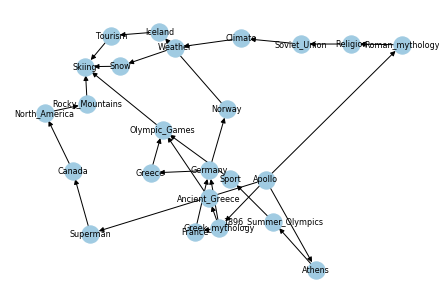

In [10]:
# load the sequences
s1 = load_sequences("Apollo", "Skiing")

# draw the directed graph
G = nx.DiGraph()
edges = []
for i in range(len(s1)):
    edges += list(zip(s1[i][:-1],s1[i][1:]))
G.add_edges_from(edges)

#dfg = plt.figure(3,figsize=(10,10)) 
pos = nx.spring_layout(G)
nx.draw(G,pos,node_color='#A0CBE2',width=1,font_size=8, with_labels=True)
plt.savefig("apollo_skiing.png")

In [11]:
# argument and write it the txt file
apollo_skiing = "Directed graph is a smiple and good method to visualize the sequential transitions. \
However the layout of the apollo_skiing directed graph is bad, there are many edges crossing each other.\
Besides some of the nodes are too close to each other which leads to overlapping and make it difficult \
to understand the graph "

outF = open("apollo_skiing.txt", "w")
outF.write("apollo_skiing visualisation argument: {0}".format(apollo_skiing))
outF.close()

## 2b) Classic link prediction metrics (0.5+0.5+1)

In this task you should compute different metrics for link prediction. Do not use functions from networkx. Assume the graph is undirected.

Write the functions `Jaccard_link(A)`, `Adamic_Adar_link(A)` and `Katz_link(A, beta)`.
The parameter A is a binary adjancency matrix (assume a 2d-numpy array, it can be dense or sparse), beta is defined in the lecture. They both return a matrix with the corresponding scores for all the nodes in the network.
Help for Katz: Search for geometric series of matrices ;). Raise a ValueError if the provided `beta` is to large.

The package networkx contains the Zachary’s Karate Club graph. It also contains functions that compute link scores. You can use it for testing.

In [12]:
import numpy as np
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).todense()
# A = A.A

In [13]:
def Jaccard_link(A):
    n = len(A)
    def calc_Jaccard(node1, node2):
        nei1 = set([i for i in range(n) if A[node1,i] == 1])
        nei2 = set([i for i in range(n) if A[node2,i] == 1])
        com_nei = nei1 & nei2
        if not com_nei: return 0
        return len(com_nei) / len(nei1|nei2)
    res = [[1]*n for i in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j: res[i][j] = calc_Jaccard(i,j)
    return np.array(res)

def Adamic_Adar_link(A):
    n = len(A)
    def calc_Adamic_Adar(node1,node2):
        nei1 = set([i for i in range(n) if A[node1,i] == 1])
        nei2 = set([i for i in range(n) if A[node2,i] == 1])
        com_nei = nei1 & nei2
        score = 0
        if com_nei:
            for i in com_nei:
                score += 1/np.log(np.sum(A[i]))
            return score
        return 0
    res = [[1]*n for i in range(n)]
    for i in range(n):
        for j in range(n):
            if i ==j : res[i][j] = 0
            else: res[i][j] = calc_Adamic_Adar(i,j)
    return np.array(res)

def Katz_link(A, beta):
    I = np.identity(len(A))
    try:
        if beta >= 1 or beta < 0: raise ValueError('incorrect beta')
        else:
            return np.linalg.inv(I-beta*A)-I
    except ValueError as e:
        raise e

## 2c) Evaluate link prediction with mean inverse rank (1.5)

To evaluate your link prediction we will use the mean inverse rank (mir). The basic idea is, that edges that really exist should be ranked higher by your metric in comparison with edges that do not exist.

Starting from train/test split of the edges you rank the missing edges according to the metric in descending order. Now for all the heldout edges you obtain the place at which this ground truth edge is in the list of edges. This is the rank of the edge. You then calculate the mean of the inverse rank (1/rank) of all heldout edges.

Write a function `cross_val_mir(G, func)` that computes the mean inverse rank for function `func` assume that the function takes a binary adjacency matrix and no other parameter. G is an undirected networkx graph. Use 10 fold cross validation on the edge set. Use np.array_split to split the edges in G into the 10 chunks. Return 1) the average mean inverse rank and 2) the standard deviation of the mir.

Apply this function to the three link prediction metrics you previously defined. Use the Zachary Karate Club graph as provided in the networkx package. Store the results as a dict 
```python
{"Jaccard" : 0.0,
 "Adamic" : 0.0,
 "Katz" : 0.0}
```
in `results_2c`. Store the beta you used for `Katz` in the variable `beta_2c`.



In [14]:
def cross_val_mir(G, func):
    edges = list(G.edges)
    split_edges = np.array_split(edges, 10)
    mir_list = [] # store mir for each 10-fold
    for i in range(10):
        test  = split_edges[i]
        train = split_edges[:i] + split_edges[i+1:]
        #create adjacent matrix
        M = np.zeros(shape = (len(G.nodes),len(G.nodes)))

        train_edges = [] #collect all trained egdges
        for edge_list in train:
            for i,j in edge_list:
                M[i][j] = 1
                M[j][i] = 1
                train_edges.append([i,j])
        # print(len(train_edges))
        M = M.astype(int)
        link_score = func(M) #calaulate metric

        missing_edges = {} # the edges not in train set. key: edge(i,j), value: score in link_score
        for i in range(len(G.nodes)):
            for j in range(i+1,len(G.nodes)):
                if [i,j] not in train_edges:
                    missing_edges[(i,j)] = link_score[i,j]
        # print(len(missing_edges))
        sorted_missing_edges = [s for s in sorted(list(set(missing_edges.values())),reverse=True)]
        # print(sorted_missing_edges)

        inverse_rank_list = []
        for edge in test:
            i,j = edge[0], edge[1]
            # print(i,j)
            rank = sorted_missing_edges.index(missing_edges[(i,j)])+1
            inverse_rank = 1/rank
            inverse_rank_list.append(inverse_rank)

        mir = np.mean(inverse_rank_list)
        mir_list.append(mir)
    # print(mir_list)
    average_mean = np.mean(mir_list)
    std = np.std(mir_list)

    return average_mean, std

In [15]:
G = nx.karate_club_graph()
m_1, std_1 = cross_val_mir(G, Jaccard_link)
m_2, std_2 = cross_val_mir(G, Adamic_Adar_link)
from functools import partial
Katz_link = partial(Katz_link,beta=0.1)
m_3, std_3 = cross_val_mir(G, Katz_link)
results_2c = {}
results_2c['Jaccard'] = [m_1, std_1]
results_2c['Adamic'] = [m_2, std_2]
results_2c['Katz'] = [m_3, std_3]
results_2c

{'Jaccard': [0.14065256087190742, 0.15348233155114244],
 'Adamic': [0.05817402426547717, 0.05240708041641596],
 'Katz': [0.02521104665648046, 0.04218175263407232]}

## 2c) Random walks on a graph (1)

Write a function `random_walks(A, start_node, length, rng)` that yields random walks of length `length` starting at node_index `start_node` on a graph given by a binary adjacency matrix `A`. Assume the graph is undirected. At each node the walker walks to another node at random. Do not use any restart conditions. At any node determine the k nodes to pick next choose that node with to go next with a call to `rng.randint(0,k)`.

In [16]:
def random_walks(A, start_node, length, rng):
    yield start_node
    for i in range(0,length):
        n = len(A)
        nei = [i for i in range(n) if A[start_node,i]==1]
        if not nei: dest_node = start_node
        else:
            dest_index = rng.randint(0,len(nei))
            dest_node = nei[dest_index]
        yield dest_node
        start_node = dest_node

In [17]:
from numpy import random as rng
list(random_walks(A, 0, 10, rng))

[0, 1, 19, 1, 19, 0, 19, 0, 10, 4, 10]

## 2d) Node2vec (1.5)

Using your function `random_walks` along with the gensim.models.Word2Vec function to train a node2vec model.
Write a helper function `get_corpus(A, length, n_per_node, rng)` that takes the binary adjacency matrix and creates a corpus (list of sequence of integers). It thereby uses the random walks function previously defined. To obtain `n_per_node` univariate sequences for each node. Go through the nodes in ascending order. Finally shuffle the list of sequences obtained using `np.permutation`. Return that sequence.

Thereafter write a function `node2vec(G, dimensions, length, n_per_node, rng)` that trains Word2Vec embeddings of a specified number of dimensions for the networkx-graph G. It first creates a corpus for graph G, using the helper function. It then relabels the corpus such that the entries are the same as in the graph. It then uses gensim.models.word2vec to train a node embedding. Use default arguments for word2vec unless specified otherwise. (Only provide the corpus and the dimensions)

In [18]:
from gensim.models import Word2Vec

def get_corpus(A, length, n_per_node, rng):
    num_nodes = len(A)
    corpus = []
    for i in range(num_nodes):
        for j in range(n_per_node):
            seq = list(random_walks(A,i,length,rng))
            corpus.append(seq)
    return np.random.permutation(corpus)

def node2vec(G, dimensions, length, n_per_node, rng):
    A = nx.adjacency_matrix(G).todense()
    corpus = get_corpus(A, length, n_per_node, rng)
    corpus_with_label = [[0]*length for i in range(len(corpus))]
    nodes_label = list(G.nodes)
    # print(nodes_label)
    for i in range(len(corpus)):
        for j in range(length):
            corpus_with_label[i][j] = str(nodes_label[corpus[i][j]])
    # print(corpus_with_label)
    model = Word2Vec(corpus_with_label, size=dimensions)
    return model

In [19]:
# load the sequences
s1 = load_sequences("Apollo", "Skiing")

# draw the directed graph
G = nx.DiGraph()
edges = []
for i in range(len(s1)):
    edges += list(zip(s1[i][:-1],s1[i][1:]))
G.add_edges_from(edges)

model = node2vec(G, 10, 20, 5, rng)
model.wv['Apollo']

array([ 0.04060218, -0.0563339 ,  0.00922851,  0.31044602, -0.03348218,
        0.39349604, -0.03087212, -0.48987803, -0.0234148 ,  0.16754717],
      dtype=float32)

## 2e) Word2Vec/Node2Vec vs Glove (1)

Explain the differences and similarities of the Anything2vec approach and Glove. Save your explanation as a string in the variable `glove`. Also write it to a file `glove.txt`

In [20]:
glove = "Similarity: Both methods can be used to train the word embedding and provide a vector per word as output. Besides, the word embedding provided\
        by both anthing2vec and Glove capture semantic relatedness and semantic similarity. Additionally both two methods have the drawback that they can not \
        provide embedding to out-of-vocalbulary words.\
        Differences: anthingtovec train the embedding based on prediction and there is a overall loss function. The optimal embedding is found\
        when the overall prediction loss is minimum. On the country, Glove train the embedding based on the cooccurance-matrix, wi * wj.T = p(i]j)\
        the product of two word vectors represents the conditional probability. The optimal embedding is found when the square error between the \
        cocurrence term log(Xij) and word vector product wi * wj.T is minumum. "

outF = open("glove.txt", "w")
outF.write("Explain the differences and similarities of the Anything2vec approach and Glove: {0}".format(glove))
outF.close()